In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5982860026147723 	 Validation loss: 0.4413806695049092 	 
  1%|          | 574/57400 [02:42<3:40:05,  4.30it/s]
Epoch 2 	 Training loss: 0.39907622290612926 	 Validation loss: 0.3596462806907751 	 
  2%|▏         | 1148/57400 [05:30<4:39:08,  3.36it/s]
Epoch 3 	 Training loss: 0.35551384896143806 	 Validation loss: 0.3420849952657344 	 
  3%|▎         | 1722/57400 [08:53<5:27:19,  2.83it/s]
Epoch 4 	 Training loss: 0.3362962825788438 	 Validation loss: 0.3342673990686061 	 
  4%|▍         | 2296/57400 [11:52<4:10:44,  3.66it/s]
Epoch 5 	 Training loss: 0.32282102962092657 	 Validation loss: 0.32399808021925264 	 
  5%|▌         | 2870/57400 [14:38<4:17:57,  3.52it/s]
Epoch 6 	 Training loss: 0.3116177339690903 	 Validation loss: 0.318986079450381 	 
  6%|▌         | 3444/57400 [17:31<4:27:51,  3.36it/s]
Epoch 7 	 Training loss: 0.3026839638265168 	 Validation loss: 0.3147095823186939 	 
  7%|▋         | 4018/57400 [20:23<4:13:38,  3.51it/s]
Epoch 8 	 Training

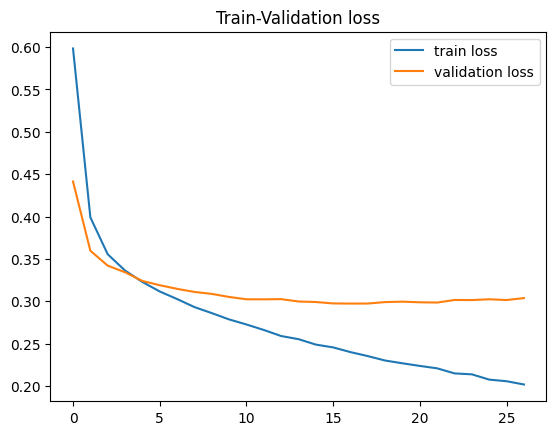

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_absolute_about'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979592, 'accuracy': 0.8431122448979592}
MALE {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}
FEMALE {'recall': 0.8325, 'precision': 0.8325, 'f1': 0.8325, 'accuracy': 0.8325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6590909090909091, 'precision': 0.6590909090909091, 'f1': 0.6590909090909091, 'accuracy': 0.6590909090909091}
MALE {'recall': 0.6934306569343066, 'precision': 0.6934306569343066, 'f1': 0.6934306569343066, 'accuracy': 0.6934306569343066}
FEMALE {'recall': 0.6220472440944882, 'precision': 0.6220472440944882, 'f1': 0.6220472440944882, 'accuracy': 0.6220472440944882} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6753585397653195, 'precision': 0.6753585397653195, 'f1': 0.6753585397653195, 'accuracy': 0.6753585397653195}
MALE {'recall': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5921780488839964 	 Validation loss: 0.4120475937754421 	 
  1%|          | 574/57400 [02:22<3:52:41,  4.07it/s]
Epoch 2 	 Training loss: 0.3852241350279452 	 Validation loss: 0.3530757624213978 	 
  2%|▏         | 1148/57400 [04:44<3:46:05,  4.15it/s]
Epoch 3 	 Training loss: 0.34977847262438166 	 Validation loss: 0.3382769408872572 	 
  3%|▎         | 1722/57400 [07:05<3:46:12,  4.10it/s]
Epoch 4 	 Training loss: 0.33047025663719776 	 Validation loss: 0.3295688096244456 	 
  4%|▍         | 2296/57400 [09:27<3:42:26,  4.13it/s]
Epoch 5 	 Training loss: 0.3180426337889263 	 Validation loss: 0.3215281097060543 	 
  5%|▌         | 2870/57400 [11:49<2:59:34,  5.06it/s]
Epoch 6 	 Training loss: 0.30811020778654347 	 Validation loss: 0.31689387913477624 	 
  6%|▌         | 3444/57400 [14:11<2:56:38,  5.09it/s]
Epoch 7 	 Training loss: 0.2974944153625375 	 Validation loss: 0.31345420292878556 	 
  7%|▋         | 4018/57400 [16:33<3:39:52,  4.05it/s]
Epoch 8 	 Traini

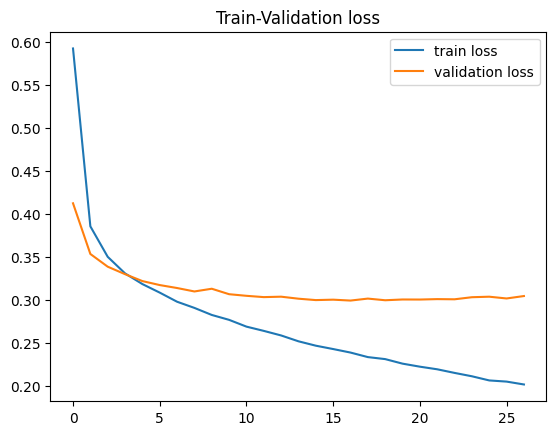

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_absolute_about2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8469387755102041, 'precision': 0.8469387755102041, 'f1': 0.8469387755102041, 'accuracy': 0.8469387755102041}
MALE {'recall': 0.859375, 'precision': 0.859375, 'f1': 0.859375, 'accuracy': 0.859375}
FEMALE {'recall': 0.835, 'precision': 0.835, 'f1': 0.835, 'accuracy': 0.835} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6641414141414141, 'precision': 0.6641414141414141, 'f1': 0.6641414141414141, 'accuracy': 0.6641414141414141}
MALE {'recall': 0.6885644768856448, 'precision': 0.6885644768856448, 'f1': 0.6885644768856448, 'accuracy': 0.6885644768856448}
FEMALE {'recall': 0.6377952755905512, 'precision': 0.6377952755905512, 'f1': 0.6377952755905512, 'accuracy': 0.6377952755905512} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6897001303780965, 'precision': 0.6897001303780965, 'f1': 0.6897001303780965, 'accuracy': 0.6897001303780965}
MALE {'recall': 0.6818181818181818, 'precision': 0.681818181

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5661799296580956 	 Validation loss: 0.40529327725960035 	 
  1%|          | 574/57400 [02:30<4:12:41,  3.75it/s]
Epoch 2 	 Training loss: 0.38233506388780547 	 Validation loss: 0.35543278895192226 	 
  2%|▏         | 1148/57400 [05:09<4:12:13,  3.72it/s]
Epoch 3 	 Training loss: 0.3489365672192922 	 Validation loss: 0.3404967744471663 	 
  3%|▎         | 1722/57400 [07:47<4:12:43,  3.67it/s]
Epoch 4 	 Training loss: 0.3314892802296615 	 Validation loss: 0.3311808245666957 	 
  4%|▍         | 2296/57400 [10:25<4:59:58,  3.06it/s]
Epoch 5 	 Training loss: 0.31716724617555997 	 Validation loss: 0.325592988123328 	 
  5%|▌         | 2870/57400 [13:04<4:05:36,  3.70it/s]
Epoch 6 	 Training loss: 0.3070290025829853 	 Validation loss: 0.3191293995764296 	 
  6%|▌         | 3444/57400 [15:44<4:02:48,  3.70it/s]
Epoch 7 	 Training loss: 0.2979773704858192 	 Validation loss: 0.3145231905124955 	 
  7%|▋         | 4018/57400 [18:22<3:55:32,  3.78it/s]
Epoch 8 	 Training

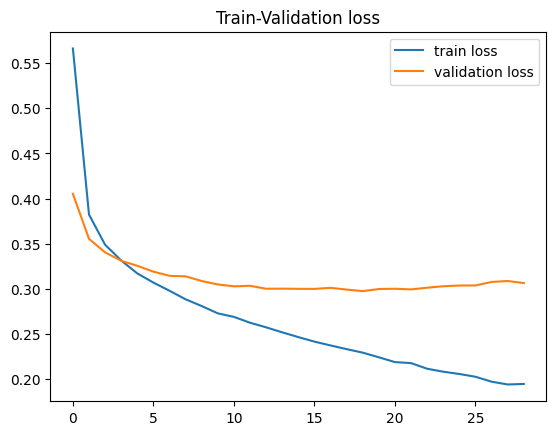

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_about3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979592, 'accuracy': 0.8431122448979592}
MALE {'recall': 0.8411458333333334, 'precision': 0.8411458333333334, 'f1': 0.8411458333333333, 'accuracy': 0.8411458333333334}
FEMALE {'recall': 0.845, 'precision': 0.845, 'f1': 0.845, 'accuracy': 0.845} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}
MALE {'recall': 0.681265206812652, 'precision': 0.681265206812652, 'f1': 0.681265206812652, 'accuracy': 0.681265206812652}
FEMALE {'recall': 0.6509186351706037, 'precision': 0.6509186351706037, 'f1': 0.6509186351706037, 'accuracy': 0.6509186351706037} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
MALE {'recall': 0.656565

Resultados finales

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8443877551020409, 'precision': 0.8443877551020409, 'f1': 0.8443877551020409, 'accuracy': 0.8443877551020409}
Métricas etiqueta male: {'recall': 0.8515625, 'precision': 0.8515625, 'f1': 0.8515625, 'accuracy': 0.8515625}
Métricas etiqueta female:  {'recall': 0.8375, 'precision': 0.8375, 'f1': 0.8375, 'accuracy': 0.8375}

 to
Resultado global: {'recall': 0.6632996632996633, 'precision': 0.6632996632996633, 'f1': 0.6632996632996633, 'accuracy': 0.6632996632996633}
Métricas etiqueta male: {'recall': 0.6877534468775345, 'precision': 0.6877534468775345, 'f1': 0.6877534468775345, 'accuracy': 0.6877534468775345}
Métricas etiqueta female:  {'recall': 0.636920384951881, 'precision': 0.636920384951881, 'f1': 0.636920384951881, 'accuracy': 0.636920384951881}

 as
Resultado global: {'recall': 0.6827466318991743, 'precision': 0.6827466318991743, 'f1': 0.6827466318991743, 'accuracy': 0.6827466318991743}
Métricas etiqueta male: {'recall': 0.66

# TO

In [21]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963995243406462 	 Validation loss: 0.6935261639498048 	 
  1%|          | 574/57400 [02:22<3:54:15,  4.04it/s]
Epoch 2 	 Training loss: 0.6950283312216038 	 Validation loss: 0.6926804397065761 	 
  2%|▏         | 1148/57400 [04:44<3:45:16,  4.16it/s]
Epoch 3 	 Training loss: 0.6944063841673556 	 Validation loss: 0.6926650586774794 	 
  3%|▎         | 1722/57400 [07:06<3:39:56,  4.22it/s]
Epoch 4 	 Training loss: 0.6940656517233167 	 Validation loss: 0.693118552030143 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:28<2:52:40,  5.32it/s]
Epoch 5 	 Training loss: 0.693768317794966 	 Validation loss: 0.6931610511521161 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [11:50<3:00:13,  5.04it/s]
Epoch 6 	 Training loss: 0.6936448702413446 	 Validation loss: 0.6938004584635719 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [14:12<3:52:24,  3.87it/s]
Epoch 7 	 Training loss: 0.6938480849050064 	 Validation loss: 0.69451863684

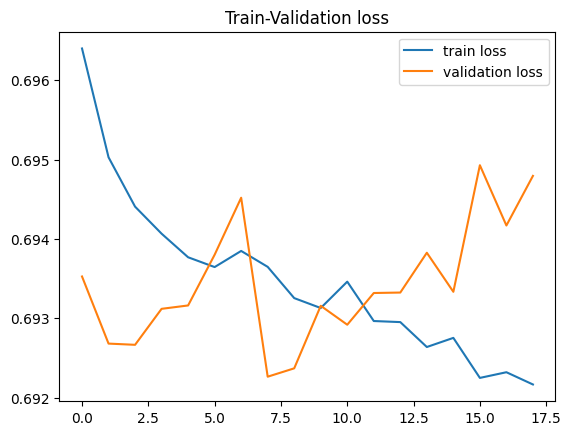

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5701530612244898, 'precision': 0.5701530612244898, 'f1': 0.5701530612244898, 'accuracy': 0.5701530612244898}
MALE {'recall': 0.3723958333333333, 'precision': 0.3723958333333333, 'f1': 0.3723958333333333, 'accuracy': 0.3723958333333333}
FEMALE {'recall': 0.76, 'precision': 0.76, 'f1': 0.76, 'accuracy': 0.76} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5593434343434344, 'precision': 0.5593434343434344, 'f1': 0.5593434343434344, 'accuracy': 0.5593434343434344}
MALE {'recall': 0.4306569343065693, 'precision': 0.4306569343065693, 'f1': 0.4306569343065693, 'accuracy': 0.4306569343065693}
FEMALE {'recall': 0.6981627296587927, 'precision': 0.6981627296587927, 'f1': 0.6981627296587927, 'accuracy': 0.6981627296587927} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5671447196870926, 'precision': 0.5671447196870926, 'f1': 0.5671447196870926, 'accuracy': 0.5671447196870926}
MALE {'recall': 0.396464

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695360654218687 	 Validation loss: 0.6929887816057367 	 
  1%|          | 574/57400 [02:23<3:47:34,  4.16it/s]
Epoch 2 	 Training loss: 0.6948002379530398 	 Validation loss: 0.6934056372965797 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:46<3:54:14,  4.00it/s]
Epoch 3 	 Training loss: 0.6938925563043002 	 Validation loss: 0.6925936492822938 	 
  3%|▎         | 1722/57400 [07:09<3:56:12,  3.93it/s]
Epoch 4 	 Training loss: 0.6940494007349846 	 Validation loss: 0.6929501729496454 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:32<3:47:29,  4.04it/s]
Epoch 5 	 Training loss: 0.6938201885813204 	 Validation loss: 0.6922996266413544 	 
  5%|▌         | 2870/57400 [11:55<3:48:21,  3.98it/s]
Epoch 6 	 Training loss: 0.6934752275304097 	 Validation loss: 0.6926971583043114 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [14:18<3:36:40,  4.15it/s]
Epoch 7 	 Training loss: 0.6932816976869564 	 Validation loss: 0.6929381691

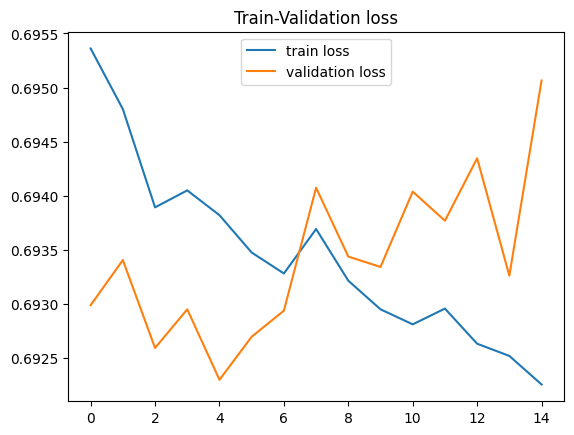

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5267857142857143, 'precision': 0.5267857142857143, 'f1': 0.5267857142857143, 'accuracy': 0.5267857142857143}
MALE {'recall': 0.2838541666666667, 'precision': 0.2838541666666667, 'f1': 0.2838541666666667, 'accuracy': 0.2838541666666667}
FEMALE {'recall': 0.76, 'precision': 0.76, 'f1': 0.76, 'accuracy': 0.76} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5315656565656566, 'precision': 0.5315656565656566, 'f1': 0.5315656565656566, 'accuracy': 0.5315656565656566}
MALE {'recall': 0.36739659367396593, 'precision': 0.36739659367396593, 'f1': 0.36739659367396593, 'accuracy': 0.36739659367396593}
FEMALE {'recall': 0.7086614173228346, 'precision': 0.7086614173228346, 'f1': 0.7086614173228346, 'accuracy': 0.7086614173228346} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4954367666232073, 'precision': 0.4954367666232073, 'f1': 0.4954367666232073, 'accuracy': 0.4954367666232073}
MALE {'recall': 0.29

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948492742997013 	 Validation loss: 0.6935281945487201 	 
  1%|          | 574/57400 [02:21<3:08:11,  5.03it/s]
Epoch 2 	 Training loss: 0.6937405174202205 	 Validation loss: 0.6924646830154677 	 
  2%|▏         | 1148/57400 [04:42<3:40:52,  4.24it/s]
Epoch 3 	 Training loss: 0.693968019730538 	 Validation loss: 0.6922791165820623 	 
  3%|▎         | 1722/57400 [07:03<3:43:27,  4.15it/s]
Epoch 4 	 Training loss: 0.6934128355896847 	 Validation loss: 0.6924662054595301 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:24<3:32:07,  4.33it/s]
Epoch 5 	 Training loss: 0.6931475614836823 	 Validation loss: 0.6923072732101052 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [11:45<3:39:58,  4.13it/s]
Epoch 6 	 Training loss: 0.6929772285426535 	 Validation loss: 0.6923365966748383 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [14:05<3:36:48,  4.15it/s]
Epoch 7 	 Training loss: 0.6927487103573536 	 Validation loss: 0.6926914241

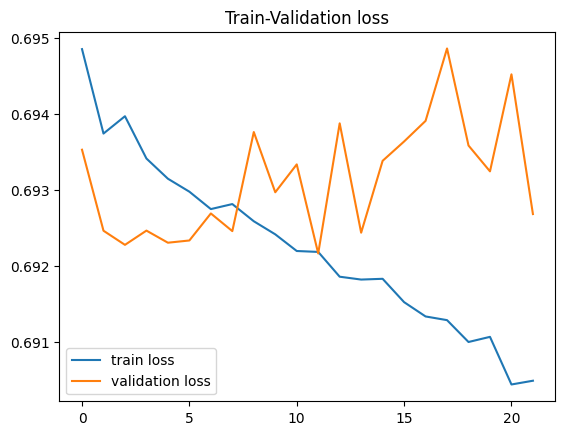

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5216836734693877, 'precision': 0.5216836734693877, 'f1': 0.5216836734693877, 'accuracy': 0.5216836734693877}
MALE {'recall': 0.2552083333333333, 'precision': 0.2552083333333333, 'f1': 0.2552083333333333, 'accuracy': 0.2552083333333333}
FEMALE {'recall': 0.7775, 'precision': 0.7775, 'f1': 0.7775, 'accuracy': 0.7775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5593434343434344, 'precision': 0.5593434343434344, 'f1': 0.5593434343434344, 'accuracy': 0.5593434343434344}
MALE {'recall': 0.340632603406326, 'precision': 0.340632603406326, 'f1': 0.340632603406326, 'accuracy': 0.340632603406326}
FEMALE {'recall': 0.7952755905511811, 'precision': 0.7952755905511811, 'f1': 0.7952755905511811, 'accuracy': 0.7952755905511811} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5358539765319427, 'precision': 0.5358539765319427, 'f1': 0.5358539765319427, 'accuracy': 0.5358539765319427}
MALE {'recall': 0.31

Resultados finales

In [28]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5395408163265306, 'precision': 0.5395408163265306, 'f1': 0.5395408163265306, 'accuracy': 0.5395408163265306}
Métricas etiqueta male: {'recall': 0.3038194444444444, 'precision': 0.3038194444444444, 'f1': 0.3038194444444444, 'accuracy': 0.3038194444444444}
Métricas etiqueta female:  {'recall': 0.7658333333333334, 'precision': 0.7658333333333334, 'f1': 0.7658333333333334, 'accuracy': 0.7658333333333334}

 to
Resultado global: {'recall': 0.5500841750841751, 'precision': 0.5500841750841751, 'f1': 0.5500841750841751, 'accuracy': 0.5500841750841751}
Métricas etiqueta male: {'recall': 0.3795620437956204, 'precision': 0.3795620437956204, 'f1': 0.3795620437956204, 'accuracy': 0.3795620437956204}
Métricas etiqueta female:  {'recall': 0.7340332458442694, 'precision': 0.7340332458442694, 'f1': 0.7340332458442694, 'accuracy': 0.7340332458442694}

 as
Resultado global: {'recall': 0.5328118209474142, 'precision': 0.5328118209474142, 'f1': 0.5

# AS

In [29]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945582018704365 	 Validation loss: 0.6919149958481223 	 
  1%|          | 574/57400 [02:20<3:48:45,  4.14it/s]
Epoch 2 	 Training loss: 0.6933354272244284 	 Validation loss: 0.6928225917331243 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:40<3:47:49,  4.12it/s]
Epoch 3 	 Training loss: 0.6917419662043608 	 Validation loss: 0.6937421782542084 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:01<3:38:40,  4.24it/s]
Epoch 4 	 Training loss: 0.689630731888349 	 Validation loss: 0.6926537317744756 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [09:21<3:32:25,  4.32it/s]
Epoch 5 	 Training loss: 0.6891583547982605 	 Validation loss: 0.6921040334943998 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [11:41<3:29:22,  4.34it/s]
Epoch 6 	 Training loss: 0.6881523243433922 	 Validation loss: 0.6914596931409027 	 
  6%|▌         | 3444/57400 [14:02<2:54:27,  5.15it/s]
Epoch 7 	 Training loss: 0.6863662059506472 	 

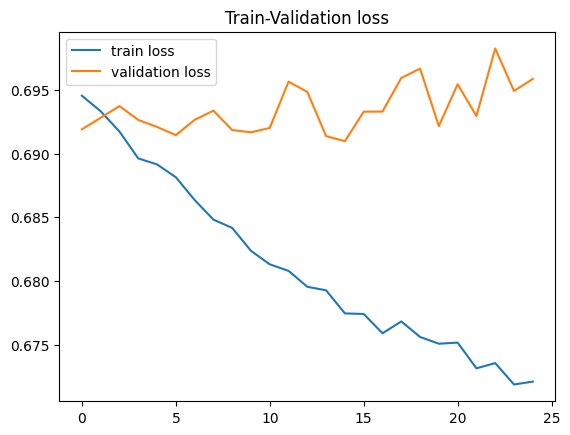

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [31]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6033163265306123, 'precision': 0.6033163265306123, 'f1': 0.6033163265306123, 'accuracy': 0.6033163265306123}
MALE {'recall': 0.6536458333333334, 'precision': 0.6536458333333334, 'f1': 0.6536458333333334, 'accuracy': 0.6536458333333334}
FEMALE {'recall': 0.555, 'precision': 0.555, 'f1': 0.555, 'accuracy': 0.555} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6641414141414141, 'precision': 0.6641414141414141, 'f1': 0.6641414141414141, 'accuracy': 0.6641414141414141}
MALE {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}
FEMALE {'recall': 0.6194225721784777, 'precision': 0.6194225721784777, 'f1': 0.6194225721784777, 'accuracy': 0.6194225721784777} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6962190352020861, 'precision': 0.6962190352020861, 'f1': 0.6962190352020861, 'accuracy': 0.6962190352020861}
MALE {'recall': 0.66

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947284884984485 	 Validation loss: 0.6933352088524123 	 
  1%|          | 574/57400 [02:07<3:30:59,  4.49it/s]
Epoch 2 	 Training loss: 0.694258627160501 	 Validation loss: 0.6919955944610854 	 
  2%|▏         | 1148/57400 [04:15<2:43:09,  5.75it/s]
Epoch 3 	 Training loss: 0.6931234068571482 	 Validation loss: 0.6916986168441126 	 
  3%|▎         | 1722/57400 [06:22<4:27:11,  3.47it/s]
Epoch 4 	 Training loss: 0.691746780577437 	 Validation loss: 0.6920509479813657 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [08:29<2:58:11,  5.15it/s]
Epoch 5 	 Training loss: 0.6907614447721621 	 Validation loss: 0.6933906048031176 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [10:36<3:13:02,  4.71it/s]
Epoch 6 	 Training loss: 0.6890564180832707 	 Validation loss: 0.6912973048323292 	 
  6%|▌         | 3444/57400 [12:44<3:10:14,  4.73it/s]
Epoch 7 	 Training loss: 0.687644310321542 	 Validation loss: 0.6914282511856596 	 

1 epoch without impr

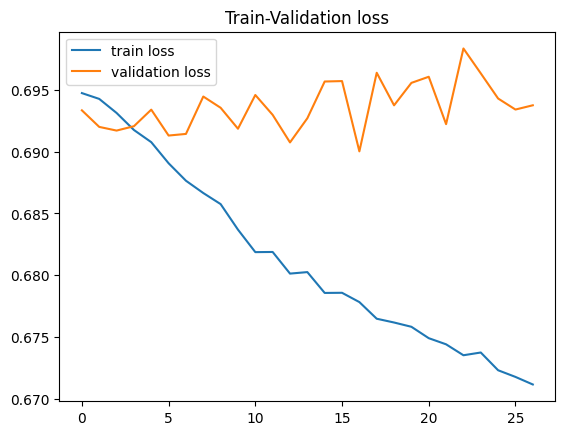

In [32]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6262755102040817, 'precision': 0.6262755102040817, 'f1': 0.6262755102040817, 'accuracy': 0.6262755102040817}
MALE {'recall': 0.5963541666666666, 'precision': 0.5963541666666666, 'f1': 0.5963541666666666, 'accuracy': 0.5963541666666666}
FEMALE {'recall': 0.655, 'precision': 0.655, 'f1': 0.655, 'accuracy': 0.655} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6717171717171717, 'precision': 0.6717171717171717, 'f1': 0.6717171717171717, 'accuracy': 0.6717171717171717}
MALE {'recall': 0.6690997566909975, 'precision': 0.6690997566909975, 'f1': 0.6690997566909975, 'accuracy': 0.6690997566909975}
FEMALE {'recall': 0.6745406824146981, 'precision': 0.6745406824146981, 'f1': 0.6745406824146981, 'accuracy': 0.6745406824146981} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6675358539765319, 'precision': 0.6675358539765319, 'f1': 0.6675358539765319, 'accuracy': 0.6675358539765319}
MALE {'recall': 0.58

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6968529577454623 	 Validation loss: 0.6929218122514628 	 
  1%|          | 574/57400 [02:06<2:49:46,  5.58it/s]
Epoch 2 	 Training loss: 0.6944146659939131 	 Validation loss: 0.6922211030782279 	 
  2%|▏         | 1148/57400 [04:13<3:13:25,  4.85it/s]
Epoch 3 	 Training loss: 0.6936564193162353 	 Validation loss: 0.6927424669265747 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [06:20<2:43:37,  5.67it/s]
Epoch 4 	 Training loss: 0.6929614521069809 	 Validation loss: 0.691939833810774 	 
  4%|▍         | 2296/57400 [08:27<3:09:22,  4.85it/s]
Epoch 5 	 Training loss: 0.6911229866099274 	 Validation loss: 0.6896805833962004 	 
  5%|▌         | 2870/57400 [10:33<3:14:53,  4.66it/s]
Epoch 6 	 Training loss: 0.6894475735646092 	 Validation loss: 0.6924526731846696 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [12:40<3:07:47,  4.79it/s]
Epoch 7 	 Training loss: 0.6886201346169781 	 Validation loss: 0.6912214058940693 	 

2 epoch without im

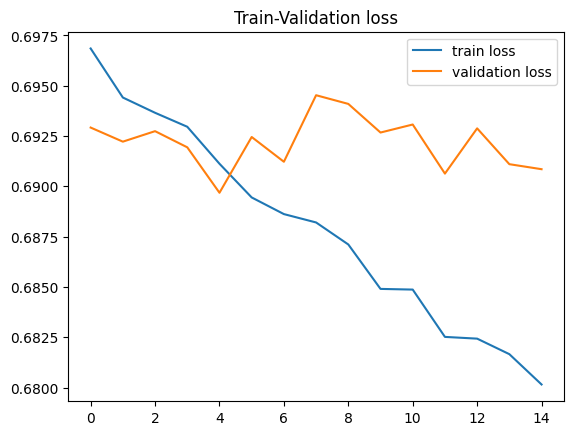

In [34]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_absolute_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5599489795918368, 'precision': 0.5599489795918368, 'f1': 0.5599489795918368, 'accuracy': 0.5599489795918368}
MALE {'recall': 0.3072916666666667, 'precision': 0.3072916666666667, 'f1': 0.3072916666666667, 'accuracy': 0.3072916666666667}
FEMALE {'recall': 0.8025, 'precision': 0.8025, 'f1': 0.8025, 'accuracy': 0.8025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5378787878787878, 'precision': 0.5378787878787878, 'f1': 0.5378787878787878, 'accuracy': 0.5378787878787878}
MALE {'recall': 0.30656934306569344, 'precision': 0.30656934306569344, 'f1': 0.30656934306569344, 'accuracy': 0.30656934306569344}
FEMALE {'recall': 0.7874015748031497, 'precision': 0.7874015748031497, 'f1': 0.7874015748031495, 'accuracy': 0.7874015748031497} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5632333767926988, 'precision': 0.5632333767926988, 'f1': 0.5632333767926988, 'accuracy': 0.5632333767926988}
MALE {'recal

Resultados finales

In [36]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5965136054421769, 'precision': 0.5965136054421769, 'f1': 0.5965136054421769, 'accuracy': 0.5965136054421769}
Métricas etiqueta male: {'recall': 0.5190972222222222, 'precision': 0.5190972222222222, 'f1': 0.5190972222222222, 'accuracy': 0.5190972222222222}
Métricas etiqueta female:  {'recall': 0.6708333333333334, 'precision': 0.6708333333333334, 'f1': 0.6708333333333334, 'accuracy': 0.6708333333333334}

 to
Resultado global: {'recall': 0.6245791245791246, 'precision': 0.6245791245791246, 'f1': 0.6245791245791246, 'accuracy': 0.6245791245791246}
Métricas etiqueta male: {'recall': 0.5604217356042174, 'precision': 0.5604217356042174, 'f1': 0.5604217356042174, 'accuracy': 0.5604217356042174}
Métricas etiqueta female:  {'recall': 0.6937882764654418, 'precision': 0.6937882764654418, 'f1': 0.6937882764654418, 'accuracy': 0.6937882764654418}

 as
Resultado global: {'recall': 0.642329421990439, 'precision': 0.642329421990439, 'f1': 0.642